<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/sjchoi86/yet-another-pytorch-tutorial/blob/main/notebook/mln.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/sjchoi86/yet-another-pytorch-tutorial/blob/main/notebook/mln.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View Source</a>
  </td>
</table>

# 만약 $\pi$만 `epis`를 줄이도록/키우도록 학습시키면?

# Mixture Logits Network (MLN)

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as TD
from torch.autograd import Variable
from torchvision import datasets,transforms
from collections import OrderedDict
%matplotlib inline
%config InlineBackend.figure_format='retina'
np.set_printoptions(precision=2)
torch.set_printoptions(precision=2)
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.7.0].
device:[cuda:1].


### Define the model

In [2]:
def np2tc(x_np): return torch.from_numpy(x_np).float().to(device)
def tc2np(x_tc): return x_tc.detach().cpu().numpy()

class MixtureOfLogits(nn.Module):
    def __init__(self,
                 in_dim     = 64,   # input feature dimension 
                 y_dim      = 10,   # number of classes 
                 k          = 5,    # number of mixtures
                 sig_min    = 1e-4, # minimum sigma
                 sig_max    = None, # maximum sigma
                 SHARE_SIG  = True  # share sigma among mixture
                 ):
        super(MixtureOfLogits,self).__init__()
        self.in_dim     = in_dim    # Q
        self.y_dim      = y_dim     # D
        self.k          = k         # K
        self.sig_min    = sig_min
        self.sig_max    = sig_max
        self.SHARE_SIG  = SHARE_SIG
        self.build_graph()

    def build_graph(self):
        self.fc_pi      = nn.Linear(self.in_dim,self.k)
        self.fc_mu      = nn.Linear(self.in_dim,self.k*self.y_dim)
        if self.SHARE_SIG:
            self.fc_sigma   = nn.Linear(self.in_dim,self.k)
        else:
            self.fc_sigma   = nn.Linear(self.in_dim,self.k*self.y_dim)

    def forward(self,x):
        """
            :param x: [N x Q]
        """
        pi_logit        = self.fc_pi(x)                                 # [N x K]
        pi              = torch.softmax(pi_logit,dim=1)                 # [N x K]
        mu              = self.fc_mu(x)                                 # [N x KD]
        mu              = torch.reshape(mu,(-1,self.k,self.y_dim))      # [N x K x D]
        if self.SHARE_SIG:
            sigma       = self.fc_sigma(x)                              # [N x K]
            sigma       = sigma.unsqueeze(dim=-1)                       # [N x K x 1]
            sigma       = sigma.expand_as(mu)                           # [N x K x D]
        else:
            sigma       = self.fc_sigma(x)                              # [N x KD]
        sigma           = torch.reshape(sigma,(-1,self.k,self.y_dim))   # [N x K x D]
        if self.sig_max is None:
            sigma = self.sig_min + torch.exp(sigma)                     # [N x K x D]
        else:
            sig_range = (self.sig_max-self.sig_min)
            sigma = self.sig_min + sig_range*torch.sigmoid(sigma)       # [N x K x D]
        mol_out = {'pi':pi,'mu':mu,'sigma':sigma}
        return mol_out

class MixtureLogitNetwork(nn.Module):
    def __init__(self,
                 name       = 'mln',        # name
                 x_dim      = [1,28,28],    # input dimension
                 k_size     = 3,            # kernel size
                 c_dims     = [32,64],      # conv channel dimensions
                 p_sizes    = [2,2],        # pooling sizes
                 h_dims     = [128],        # hidden dimensions
                 y_dim      = 10,           # output dimension
                 USE_BN     = True,         # whether to use batch-norm
                 k          = 5,            # number of mixtures
                 sig_min    = 1e-4,         # minimum sigma
                 sig_max    = 10,           # maximum sigma
                 mu_min     = -3,           # minimum mu (init)
                 mu_max     = +3,           # maximum mu (init)
                 SHARE_SIG  = True          
                 ):
        super(MixtureLogitNetwork,self).__init__()
        self.name       = name
        self.x_dim      = x_dim
        self.k_size     = k_size
        self.c_dims     = c_dims
        self.p_sizes    = p_sizes
        self.h_dims     = h_dims
        self.y_dim      = y_dim
        self.USE_BN     = USE_BN
        self.k          = k
        self.sig_min    = sig_min
        self.sig_max    = sig_max
        self.mu_min     = mu_min
        self.mu_max     = mu_max
        self.SHARE_SIG  = SHARE_SIG
        self.build_graph()
        self.init_param()

    def build_graph(self):
        self.layers = []
        # Conv layers
        prev_c_dim = self.x_dim[0] # input channel 
        for (c_dim,p_size) in zip(self.c_dims,self.p_sizes):
            self.layers.append(
                nn.Conv2d(
                    in_channels  = prev_c_dim,
                    out_channels = c_dim,
                    kernel_size  = self.k_size,
                    stride       = (1,1),
                    padding      = self.k_size//2
                    ) # conv
                )
            if self.USE_BN:
                self.layers.append(
                    nn.BatchNorm2d(num_features=c_dim)
                )
            self.layers.append(nn.ReLU())
            self.layers.append(
                nn.MaxPool2d(kernel_size=(p_size,p_size),stride=(p_size,p_size))
                )
            # self.layers.append(nn.Dropout2d(p=0.1))  # p: to be zero-ed
            prev_c_dim = c_dim 
        # Dense layers
        self.layers.append(nn.Flatten())
        p_prod = np.prod(self.p_sizes)
        prev_h_dim = prev_c_dim*(self.x_dim[1]//p_prod)*(self.x_dim[2]//p_prod)
        for h_dim in self.h_dims:
            self.layers.append(
                nn.Linear(
                    in_features  = prev_h_dim,
                    out_features = h_dim,
                    bias         = True
                    )
                )
            self.layers.append(nn.ReLU(True))  # activation
            self.layers.append(nn.Dropout2d(p=0.1))  # p: to be zero-ed
            prev_h_dim = h_dim
        # Final mixture of logits layer
        self.mol = MixtureOfLogits(
            in_dim      = prev_h_dim,  
            y_dim       = self.y_dim, 
            k           = self.k,
            sig_min     = self.sig_min,
            sig_max     = self.sig_max,
            SHARE_SIG   = self.SHARE_SIG
        )
        self.layers.append(self.mol)
        # Concatanate all layers
        self.net = nn.Sequential()
        for l_idx,layer in enumerate(self.layers):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
            self.net.add_module(layer_name,layer)

    def forward(self,x):
        mln_out = self.net(x)
        return mln_out # mu:[N x K x D] / pi:[N x K] / sigma:[N x K x D]

    def init_param(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            if isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
        # Heuristic: fc_mu.bias ~ Uniform(mu_min,mu_max)
        self.layers[-1].fc_mu.bias.data.uniform_(self.mu_min,self.mu_max)
        
    def get_pi_params(self):
        return self.mol.fc_pi.parameters()
    def get_other_params(self):
        p_pi = [id(p) for p in self.get_pi_params()]
        return [p for p in self.parameters() if id(p) not in p_pi]

In [3]:
def mln_uncertainties(pi,mu,sigma):
    """
        :param pi:      [N x K]
        :param mu:      [N x K x D]
        :param sigma:   [N x K x D]
    """
    # $\pi$
    mu_hat = torch.softmax(mu,dim=2) # logit to prob [N x K x D]
    pi_usq = torch.unsqueeze(pi,2) # [N x K x 1]
    pi_exp = pi_usq.expand_as(sigma) # [N x K x D]
    # softmax($\mu$) average
    mu_hat_avg = torch.sum(torch.mul(pi_exp,mu_hat),dim=1).unsqueeze(1) # [N x 1 x D]
    mu_hat_avg_exp = mu_hat_avg.expand_as(mu) # [N x K x D]
    mu_hat_diff_sq = torch.square(mu_hat-mu_hat_avg_exp) # [N x K x D]
    # Epistemic uncertainty
    epis = torch.sum(torch.mul(pi_exp,mu_hat_diff_sq), dim=1)  # [N x D]
    epis = torch.sqrt(torch.sum(epis,dim=1)) # [N]
    # Aleatoric uncertainty
    alea = torch.sum(torch.mul(pi_exp,sigma), dim=1)  # [N x D]
    alea = torch.sqrt(torch.mean(alea,dim=1)) # [N]
    # Return
    unct_out = {'epis':epis, # [N]
                'alea':alea  # [N]
                }
    return unct_out

def mace_loss(pi,mu,sigma,target):
    """
        :param pi:      [N x K]
        :param mu:      [N x K x D]
        :param sigma:   [N x K x D]
        :param target:  [N x D]
    """
    # $\mu$
    mu_hat = torch.softmax(mu,dim=2) # logit to prob [N x K x D]
    log_mu_hat = torch.log(mu_hat+1e-6) # [N x K x D]
    # $\pi$
    pi_usq = torch.unsqueeze(pi,2) # [N x K x 1]
    pi_exp = pi_usq.expand_as(mu) # [N x K x D]
    # target
    target_usq =  torch.unsqueeze(target,1) # [N x 1 x D]
    target_exp =  target_usq.expand_as(mu) # [N x K x D]
    # CE loss
    ce_exp = -target_exp*log_mu_hat # CE [N x K x D]
    
    ace_exp = ce_exp / sigma # attenuated CE [N x K x D]
    mace_exp = torch.mul(pi_exp,ace_exp) # mixtured attenuated CE [N x K x D]
    mace = torch.sum(mace_exp,dim=1) # [N x D]
    mace = torch.sum(mace,dim=1) # [N]
    mace_avg = torch.mean(mace) # [1]
    # Compute uncertainties (epis and alea)
    unct_out = mln_uncertainties(pi,mu,sigma)
    epis = unct_out['epis'] # [N]
    alea = unct_out['alea'] # [N]
    epis_avg = torch.mean(epis) # [1]
    alea_avg = torch.mean(alea) # [1]
    # Return
    loss_out = {'mace':mace, # [N]
                'mace_avg':mace_avg, # [1]
                'epis':epis, # [N]
                'alea':alea, # [N]
                'epis_avg':epis_avg, # [1]
                'alea_avg':alea_avg # [1]
                }
    return loss_out

def mln_gather(pi,mu,sigma):
    """
        :param pi:      [N x K]
        :param mu:      [N x K x D]
        :param sigma:   [N x K x D]
    """
    max_idx = torch.argmax(pi,dim=1) # [N]
    idx_gather = max_idx.unsqueeze(dim=-1).repeat(1,mu.shape[2]).unsqueeze(1) # [N x 1 x D]
    mu_sel = torch.gather(mu,dim=1,index=idx_gather).squeeze(dim=1) # [N x D]
    sigma_sel = torch.gather(sigma,dim=1,index=idx_gather).squeeze(dim=1) # [N x D]
    out = {'max_idx':max_idx, # [N]
           'idx_gather':idx_gather, # [N x 1 x D]
           'mu_sel':mu_sel, # [N x D]
           'sigma_sel':sigma_sel # [N x D]
           }
    return out

def func_eval(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct,epis_unct_sum,alea_unct_sum = 0,0,0,0
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in,batch_out in data_iter:
            # Foraward path
            y_trgt = batch_out.to(device)
            mln_out = model.forward(batch_in.view(-1,1,28,28).to(device))
            pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
            out = mln_gather(pi,mu,sigma)
            model_pred = out['mu_sel']

            # Compute uncertainty 
            unct_out = mln_uncertainties(pi,mu,sigma)
            epis_unct = unct_out['epis'] # [N]
            alea_unct = unct_out['alea'] # [N]
            epis_unct_sum += torch.sum(epis_unct)
            alea_unct_sum += torch.sum(alea_unct)

            # Check predictions
            _,y_pred = torch.max(model_pred,1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        epis = (epis_unct_sum/n_total).detach().cpu().item()
        alea = (alea_unct_sum/n_total).detach().cpu().item()
        model.train() # back to train mode 
        out_eval = {'val_accr':val_accr,'epis':epis,'alea':alea}
    return out_eval

# Demo forward path of MLN
M = MixtureLogitNetwork(k=3,SHARE_SIG=True).to(device)
x = torch.rand([2]+M.x_dim).to(device)
target = F.one_hot(torch.randint(low=0,high=10,size=(2,)),num_classes=10).to(device) 
mln_out = M.forward(x)
pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
mu_sel = mln_gather(pi,mu,sigma)['mu_sel']
loss_out = mace_loss(pi,mu,sigma,target)
loss = loss_out['mace_avg'] - loss_out['epis_avg'] # epis as a regularizer 
loss.backward() # backward propagation 
print ("x:       %s"%(tc2np(x).shape,))
print ("=>")
print ("pi:    %s\n%s"%(tc2np(pi).shape,tc2np(pi)))
print ("mu:    %s\n%s"%(tc2np(mu).shape,tc2np(mu)))
print ("sigma: %s\n%s"%(tc2np(sigma).shape,tc2np(sigma)))
print ("=>")
print ("mace:[%.3f] epis:[%.3f] alea:[%.3f]"%
       (loss_out['mace_avg'],loss_out['epis_avg'],loss_out['alea_avg']))

x:       (2, 1, 28, 28)
=>
pi:    (2, 3)
[[0.13 0.58 0.3 ]
 [0.01 0.85 0.14]]
mu:    (2, 3, 10)
[[[-2.98e-01 -5.43e-01  5.40e-02  5.40e-01  2.12e+00 -4.80e+00  4.20e+00
    1.63e+00  6.56e-01 -3.06e-02]
  [-3.38e+00 -3.74e+00 -2.28e+00 -3.97e-01  2.26e-02  3.11e+00  1.35e+00
    3.48e-01  7.63e-01  3.66e+00]
  [ 1.18e+00 -5.22e+00 -1.64e+00  9.44e-02  3.53e+00 -3.40e+00 -1.71e+00
    1.42e+00  4.26e-01 -3.75e+00]]

 [[-4.59e-01  2.42e-01  5.06e-01 -1.38e+00  5.18e-01 -3.44e+00  5.23e+00
    9.98e-01  1.68e+00  1.61e-03]
  [-2.50e+00 -4.63e+00 -1.08e+00 -5.14e-01  1.46e-01  2.99e+00  1.37e-01
   -6.01e-01  1.39e+00  2.38e+00]
  [ 3.21e+00 -5.31e+00 -7.58e-01 -2.12e-01  3.51e+00 -3.54e+00 -1.49e+00
    3.29e-01 -3.24e-01 -5.33e+00]]]
sigma: (2, 3, 10)
[[[6.43 6.43 6.43 6.43 6.43 6.43 6.43 6.43 6.43 6.43]
  [8.76 8.76 8.76 8.76 8.76 8.76 8.76 8.76 8.76 8.76]
  [3.2  3.2  3.2  3.2  3.2  3.2  3.2  3.2  3.2  3.2 ]]

 [[7.93 7.93 7.93 7.93 7.93 7.93 7.93 7.93 7.93 7.93]
  [9.39 9.39 9.39 9.39

### Dataset

In [4]:
def get_train_iter(rs_rate=0.0,rp_rate=0.0,BATCH_SIZE=64):
    mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
    n_train = len(mnist_train) 
    # Random shuffle
    if rs_rate > 0:
        n_rs = int(n_train*rs_rate) 
        r_idx = np.random.permutation(n_train)[:n_rs]
        mnist_train.targets[r_idx] = torch.randint(low=0,high=10,size=(n_rs,)) # random label 
    # Random permute
    if rp_rate > 0:
        permute_labels = [1,2,3,4,5,6,7,8,9,0] 
        targets = mnist_train.targets
        sel_idxs = []
        for label in range(10):
            sel_idx = torch.where(targets==label)[0]
            sel_idxs.append(sel_idx)
        for label in range(10):
            sel_idx = sel_idxs[label]
            n_sel = sel_idx.shape[0]
            corrupt_idx = np.random.permutation(n_sel)[:int(n_sel*rp_rate)]
            mnist_train.targets[sel_idx[corrupt_idx]] = permute_labels[label]
    # Train iterator 
    train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
    return train_iter
def get_test_iter(BATCH_SIZE=64):
    mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
    test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)    
    return test_iter
print ("Done.")

Done.


### Evaluation

In [5]:
train_iter,test_iter = get_train_iter(),get_test_iter()
M = MixtureLogitNetwork(k=3,SHARE_SIG=True).to(device)
M.init_param()
train_accr = func_eval(M,train_iter,device)['val_accr']
test_accr = func_eval(M,test_iter,device)['val_accr']
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[0.085] test_accr:[0.083].


### Train

In [6]:
def train_wrapper(rs_rate=0.0,rp_rate=0.0,EPOCHS=10):
    np.set_printoptions(formatter={'float_kind':'{:.2f}'.format})
    M = MixtureLogitNetwork(name='mln',x_dim=[1,28,28],k_size=3,c_dims=[32,64],p_sizes=[2,2],
                            h_dims=[128,64],y_dim=10,USE_BN=False,k=10,
                            sig_min=0.1,sig_max=10.0, # not using sigma here
                            mu_min=-1,mu_max=+1,SHARE_SIG=True).to(device)
    np.random.seed(seed=0)
    torch.manual_seed(seed=0) # fix random seed                            
    M.init_param()
    optm = optim.Adam(M.parameters(),lr=1e-3,weight_decay=1e-6)
    optm_pi = optim.Adam(M.get_pi_params(),lr=1e-3,weight_decay=1e-6)
    M.train() # train mode
    train_iter = get_train_iter(rs_rate=rs_rate,rp_rate=rp_rate,BATCH_SIZE=128)
    test_iter = get_test_iter(BATCH_SIZE=128)
    print_every = 1
    for epoch in range(EPOCHS):
        loss_sum = 0.0
        for batch_in,batch_out in train_iter:
            # Forward path
            mln_out = M.forward(batch_in.view(-1,1,28,28).to(device)) 
            pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
            target = torch.eye(M.y_dim)[batch_out].to(device)
            loss_out = mace_loss(pi,mu,sigma,target) # 'mace_avg','epis_avg','alea_avg'
#             loss = loss_out['mace_avg'] - loss_out['epis_avg'] + loss_out['alea_avg']
            loss = loss_out['mace_avg'] + loss_out['alea_avg']
            loss_epis = - loss_out['epis_avg']
            # Update 
            optm.zero_grad() # reset gradient 
            optm_pi.zero_grad()
            loss.backward(retain_graph=True) # back-propagation 
            loss_epis.backward()
            optm.step() # optimizer update
            optm_pi.step()
            # Track losses 
            loss_sum += loss
        loss_avg = loss_sum/len(train_iter)
        # Print
        if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
            train_res = func_eval(M,train_iter,device)
            test_res  = func_eval(M,test_iter,device)
            print ("epoch:[%d/%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
                (epoch,EPOCHS,loss_avg,train_res['val_accr'],test_res['val_accr'])) 
            print (" [Train] alea:[%.3f] epis:[%.3f] / [Test] alea:[%.3f] epis:[%.3f]"%
                (train_res['alea'],train_res['epis'],test_res['alea'],test_res['epis']))
    out = {'M':M,'train_iter':train_iter,'test_iter':test_iter}

    # Check the trained results
    M = out['M']
    test_iter,train_iter = out['test_iter'],out['train_iter']

    mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
    n_sample = 25
    sample_indices = np.random.choice(len(mnist_test.targets),n_sample,replace=False)
    test_x = mnist_test.data[sample_indices]
    test_y = mnist_test.targets[sample_indices]

    x = test_x.view(-1,1,28,28).type(torch.float).to(device)/255.
    mln_out = M.forward(x)
    pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
    target = torch.eye(M.y_dim)[test_y].to(device)
    loss_out = mace_loss(pi,mu,sigma,target) # 'mace_avg','epis_avg','alea_avg'

    # Get the first and second-best prediction
    y_pred = []
    y_second = []
    pi_np,mu_np,sigma_np = tc2np(pi),tc2np(mu),tc2np(sigma)
    for idx in range(n_sample):
        pi_i,mu_i = pi_np[idx,:],mu_np[idx,:]
        sort_idx = np.argsort(-pi_i)
        y_pred.append(np.argmax(mu_i[sort_idx[0]]))
        y_second.append(np.argmax(mu_i[sort_idx[1]]))

    # Plot results
    plt.figure(figsize=(10,10))
    for idx in range(n_sample):
        plt.subplot(5, 5, idx+1)
        plt.imshow(test_x[idx], cmap='gray')
        plt.axis('off')
        plt.title("[%d] 1st:[%d] 2nd:[%d]"%
                (test_y[idx],y_pred[idx],y_second[idx]))
    plt.show()    
    print ("Done")

    # Print-out the mixture wegiths
    print ('pi:\n%s'%(pi_np[:5,:])) # print upto five 
    return out 
print ("Done.")

Done.


### Clean data

epoch:[0/10] loss:[1.447] train_accr:[0.971] test_accr:[0.972].
 [Train] alea:[0.627] epis:[0.256] / [Test] alea:[0.616] epis:[0.252]
epoch:[1/10] loss:[0.797] train_accr:[0.980] test_accr:[0.981].
 [Train] alea:[0.493] epis:[0.227] / [Test] alea:[0.485] epis:[0.224]
epoch:[2/10] loss:[0.699] train_accr:[0.984] test_accr:[0.984].
 [Train] alea:[0.492] epis:[0.249] / [Test] alea:[0.484] epis:[0.247]
epoch:[3/10] loss:[0.647] train_accr:[0.984] test_accr:[0.982].
 [Train] alea:[0.504] epis:[0.243] / [Test] alea:[0.499] epis:[0.242]
epoch:[4/10] loss:[0.618] train_accr:[0.990] test_accr:[0.985].
 [Train] alea:[0.450] epis:[0.233] / [Test] alea:[0.445] epis:[0.232]
epoch:[5/10] loss:[0.578] train_accr:[0.990] test_accr:[0.988].
 [Train] alea:[0.443] epis:[0.237] / [Test] alea:[0.438] epis:[0.236]
epoch:[6/10] loss:[0.572] train_accr:[0.992] test_accr:[0.988].
 [Train] alea:[0.449] epis:[0.244] / [Test] alea:[0.446] epis:[0.244]
epoch:[7/10] loss:[0.554] train_accr:[0.994] test_accr:[0.990]

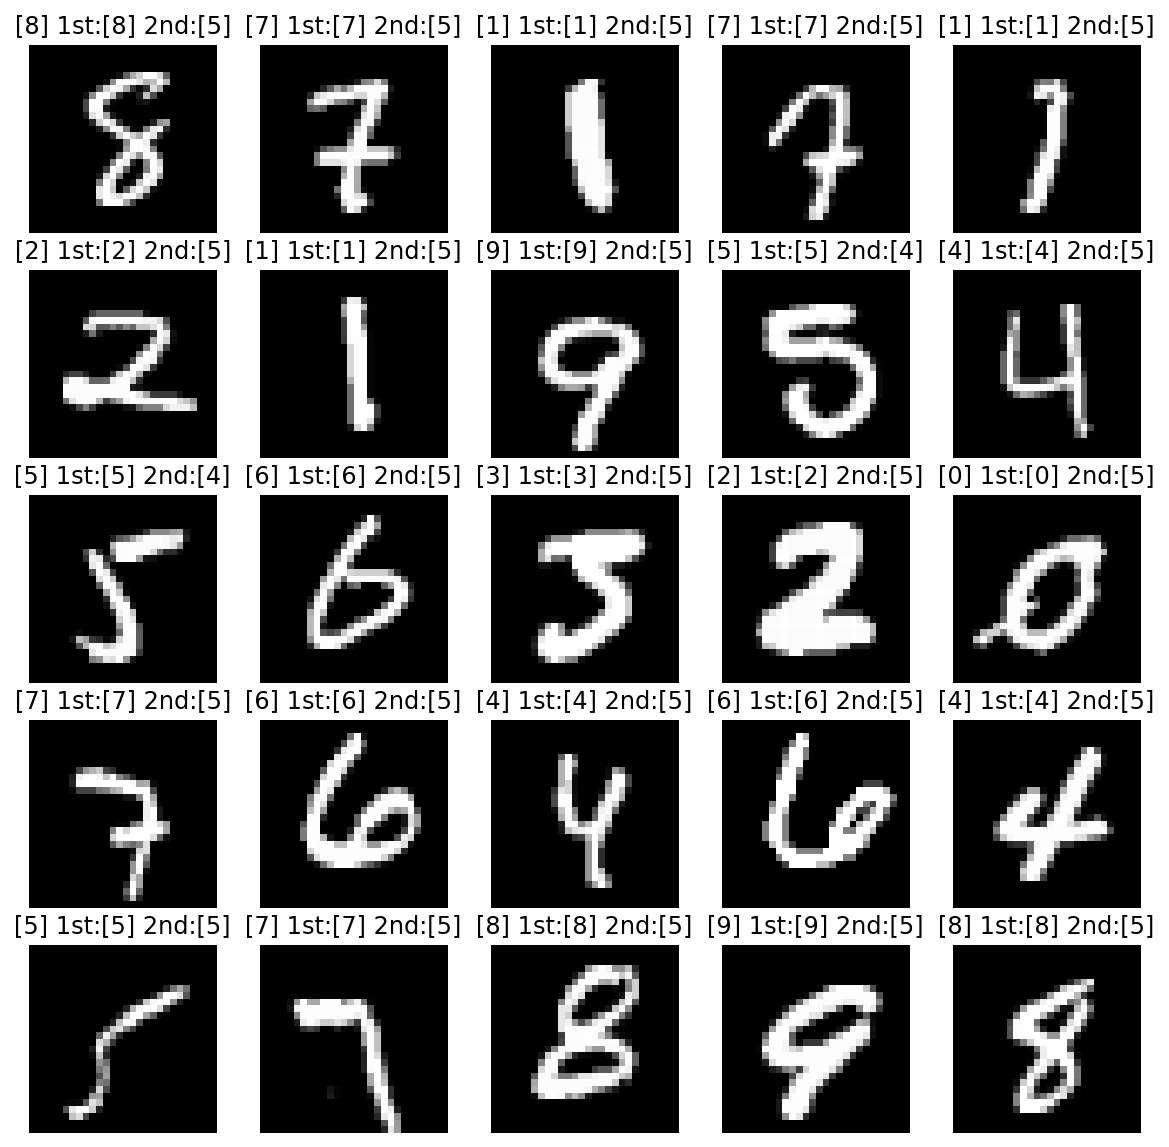

Done
pi:
[[0.00 0.00 0.00 0.03 0.00 0.00 0.00 0.00 0.97 0.00]
 [0.00 0.00 0.00 0.00 0.95 0.00 0.00 0.00 0.00 0.05]
 [0.00 0.01 0.00 0.04 0.00 0.01 0.00 0.00 0.94 0.00]
 [0.00 0.00 0.00 0.00 0.93 0.00 0.00 0.00 0.00 0.07]
 [0.00 0.00 0.00 0.04 0.00 0.00 0.00 0.00 0.96 0.00]]


In [7]:
out1 = train_wrapper(rs_rate=0.0,rp_rate=0.0)

### Random shuffle

epoch:[0/10] loss:[2.810] train_accr:[0.203] test_accr:[0.617].
 [Train] alea:[1.893] epis:[0.658] / [Test] alea:[1.892] epis:[0.658]
epoch:[1/10] loss:[2.789] train_accr:[0.246] test_accr:[0.821].
 [Train] alea:[1.870] epis:[0.679] / [Test] alea:[1.870] epis:[0.679]
epoch:[2/10] loss:[2.779] train_accr:[0.252] test_accr:[0.853].
 [Train] alea:[1.861] epis:[0.684] / [Test] alea:[1.861] epis:[0.684]
epoch:[3/10] loss:[2.773] train_accr:[0.253] test_accr:[0.850].
 [Train] alea:[1.859] epis:[0.680] / [Test] alea:[1.859] epis:[0.680]
epoch:[4/10] loss:[2.769] train_accr:[0.257] test_accr:[0.864].
 [Train] alea:[1.852] epis:[0.684] / [Test] alea:[1.852] epis:[0.683]
epoch:[5/10] loss:[2.766] train_accr:[0.259] test_accr:[0.856].
 [Train] alea:[1.847] epis:[0.678] / [Test] alea:[1.847] epis:[0.678]
epoch:[6/10] loss:[2.762] train_accr:[0.261] test_accr:[0.857].
 [Train] alea:[1.845] epis:[0.677] / [Test] alea:[1.846] epis:[0.677]
epoch:[7/10] loss:[2.759] train_accr:[0.265] test_accr:[0.836]

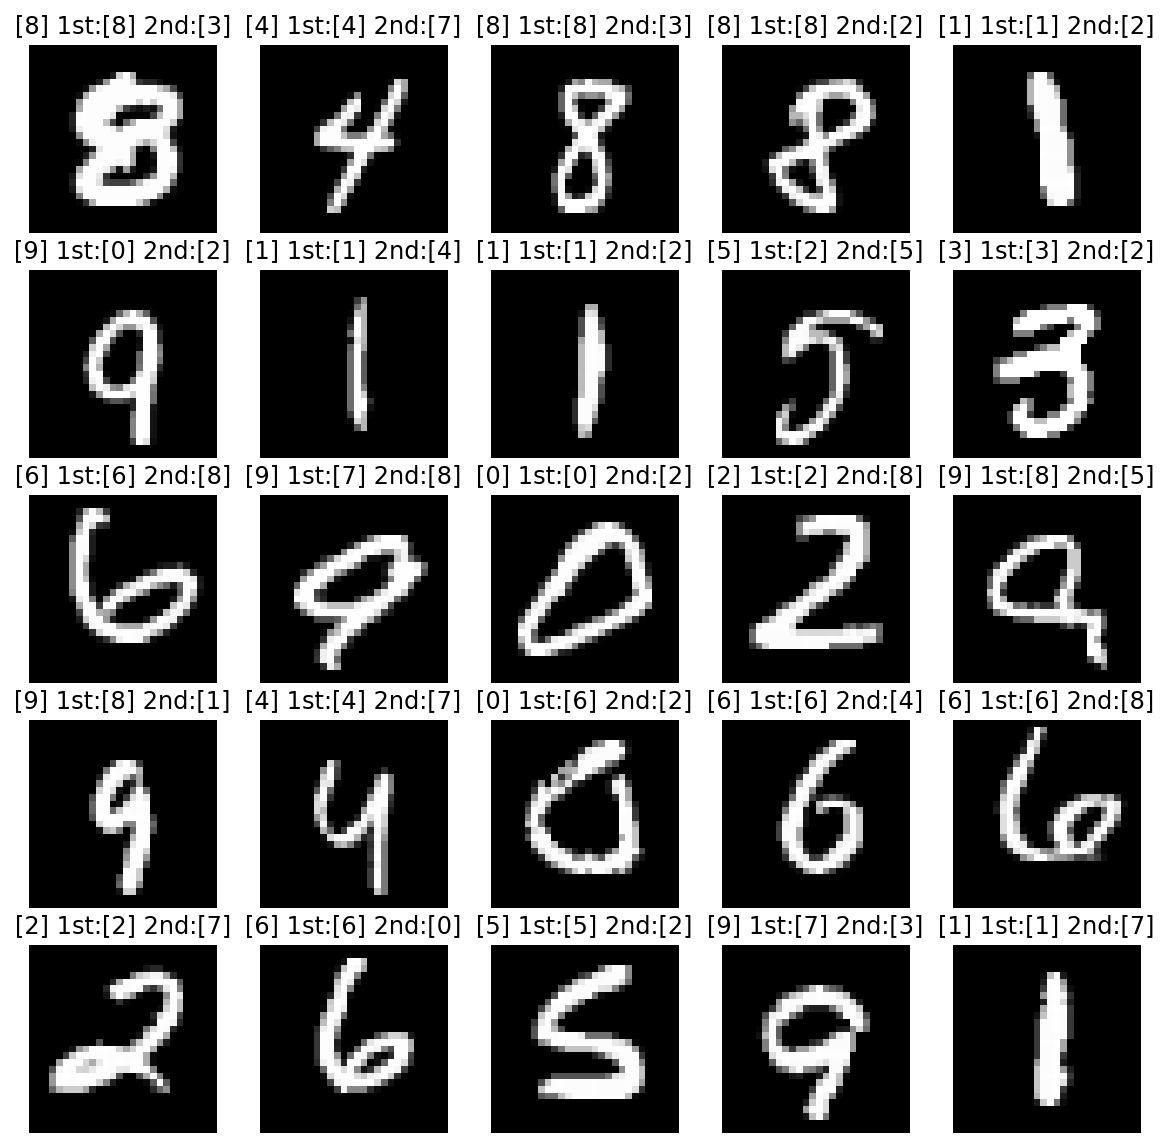

Done
pi:
[[0.10 0.10 0.14 0.10 0.08 0.16 0.00 0.12 0.08 0.10]
 [0.06 0.06 0.12 0.05 0.21 0.08 0.00 0.28 0.07 0.07]
 [0.11 0.10 0.16 0.06 0.10 0.22 0.00 0.09 0.07 0.09]
 [0.15 0.09 0.07 0.08 0.09 0.17 0.00 0.10 0.10 0.14]
 [0.14 0.08 0.12 0.08 0.08 0.10 0.00 0.10 0.21 0.10]]


In [8]:
out2 = train_wrapper(rs_rate=0.8,rp_rate=0.0)

### Random permute

epoch:[0/10] loss:[2.324] train_accr:[0.552] test_accr:[0.805].
 [Train] alea:[1.422] epis:[0.449] / [Test] alea:[1.419] epis:[0.447]
epoch:[1/10] loss:[2.007] train_accr:[0.575] test_accr:[0.887].
 [Train] alea:[1.384] epis:[0.458] / [Test] alea:[1.384] epis:[0.459]
epoch:[2/10] loss:[1.964] train_accr:[0.590] test_accr:[0.956].
 [Train] alea:[1.312] epis:[0.442] / [Test] alea:[1.312] epis:[0.442]
epoch:[3/10] loss:[1.941] train_accr:[0.593] test_accr:[0.959].
 [Train] alea:[1.308] epis:[0.453] / [Test] alea:[1.309] epis:[0.454]
epoch:[4/10] loss:[1.928] train_accr:[0.595] test_accr:[0.973].
 [Train] alea:[1.275] epis:[0.447] / [Test] alea:[1.275] epis:[0.448]
epoch:[5/10] loss:[1.916] train_accr:[0.596] test_accr:[0.966].
 [Train] alea:[1.325] epis:[0.466] / [Test] alea:[1.325] epis:[0.467]
epoch:[6/10] loss:[1.910] train_accr:[0.599] test_accr:[0.976].
 [Train] alea:[1.284] epis:[0.461] / [Test] alea:[1.284] epis:[0.462]
epoch:[7/10] loss:[1.902] train_accr:[0.599] test_accr:[0.974]

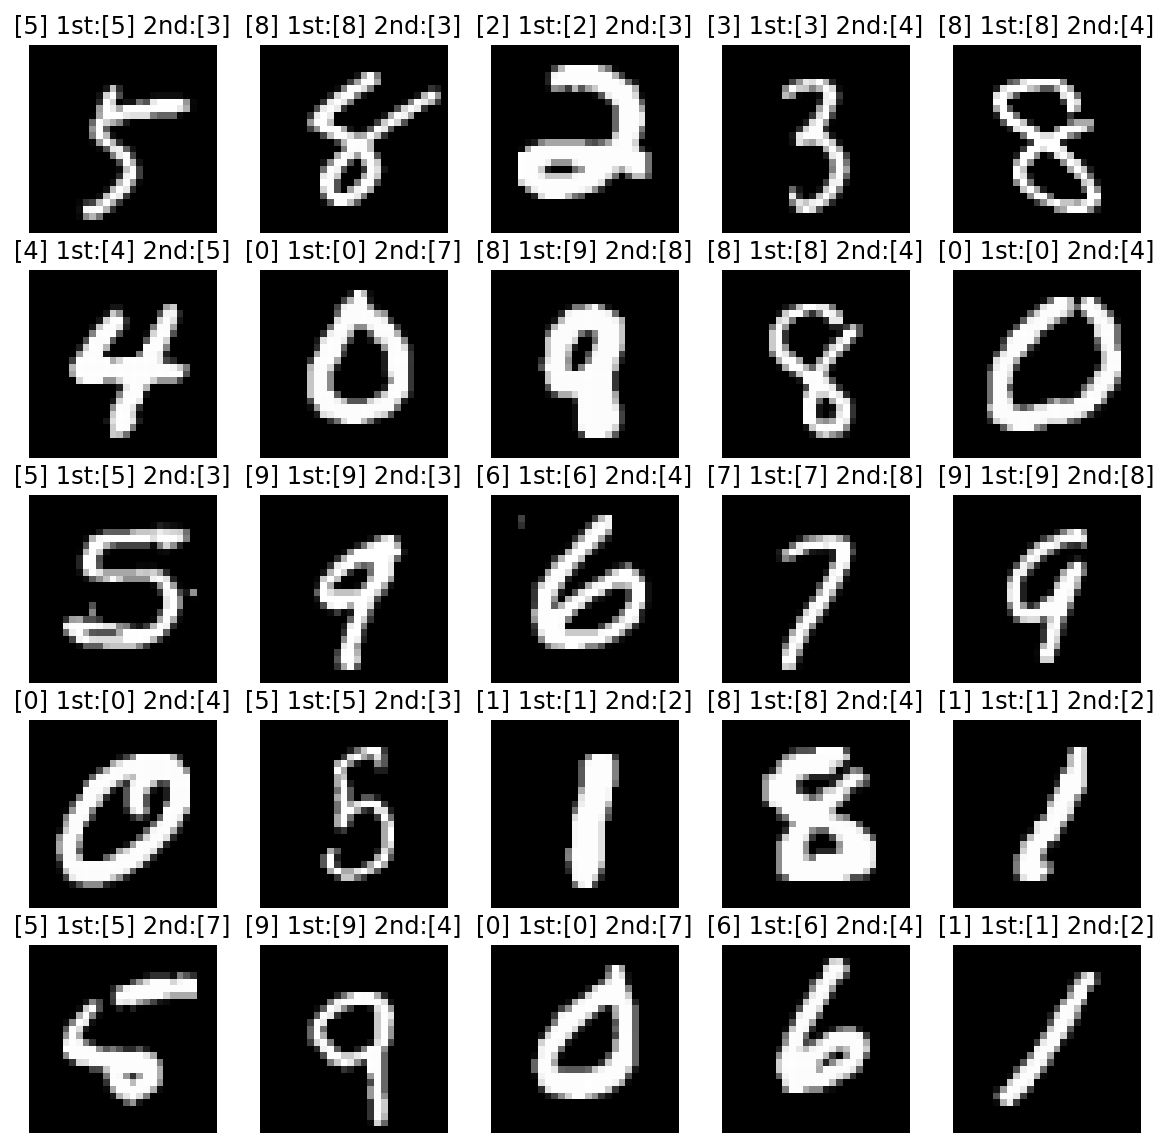

Done
pi:
[[0.00 0.06 0.08 0.04 0.00 0.00 0.00 0.00 0.00 0.83]
 [0.00 0.04 0.08 0.03 0.00 0.00 0.00 0.00 0.78 0.07]
 [0.59 0.03 0.34 0.04 0.00 0.00 0.00 0.00 0.00 0.00]
 [0.00 0.35 0.64 0.00 0.00 0.00 0.00 0.00 0.00 0.01]
 [0.00 0.05 0.04 0.02 0.00 0.00 0.00 0.00 0.86 0.02]]


In [9]:
out3 = train_wrapper(rs_rate=0.0,rp_rate=0.4)

In [10]:
M1, M2, M3 = out1['M'], out2['M'], out3['M']

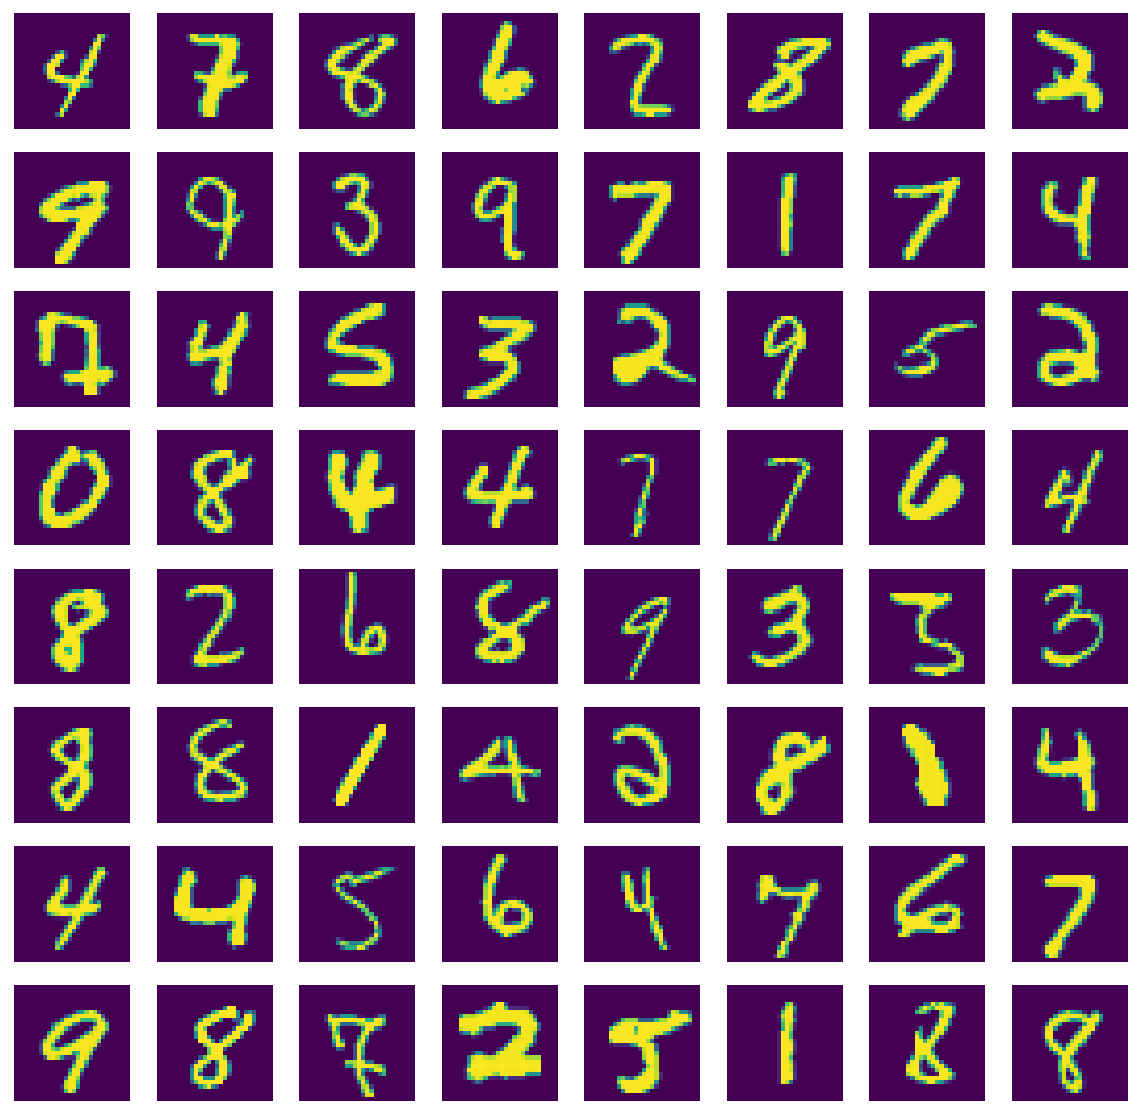

In [11]:
for images, labels in get_test_iter():
    break

plt.figure(figsize=(10, 10))
for i, image in enumerate(images):
    plt.subplot(8, 8, i+1)
    plt.imshow(image.squeeze()); plt.axis('off')
plt.show() 

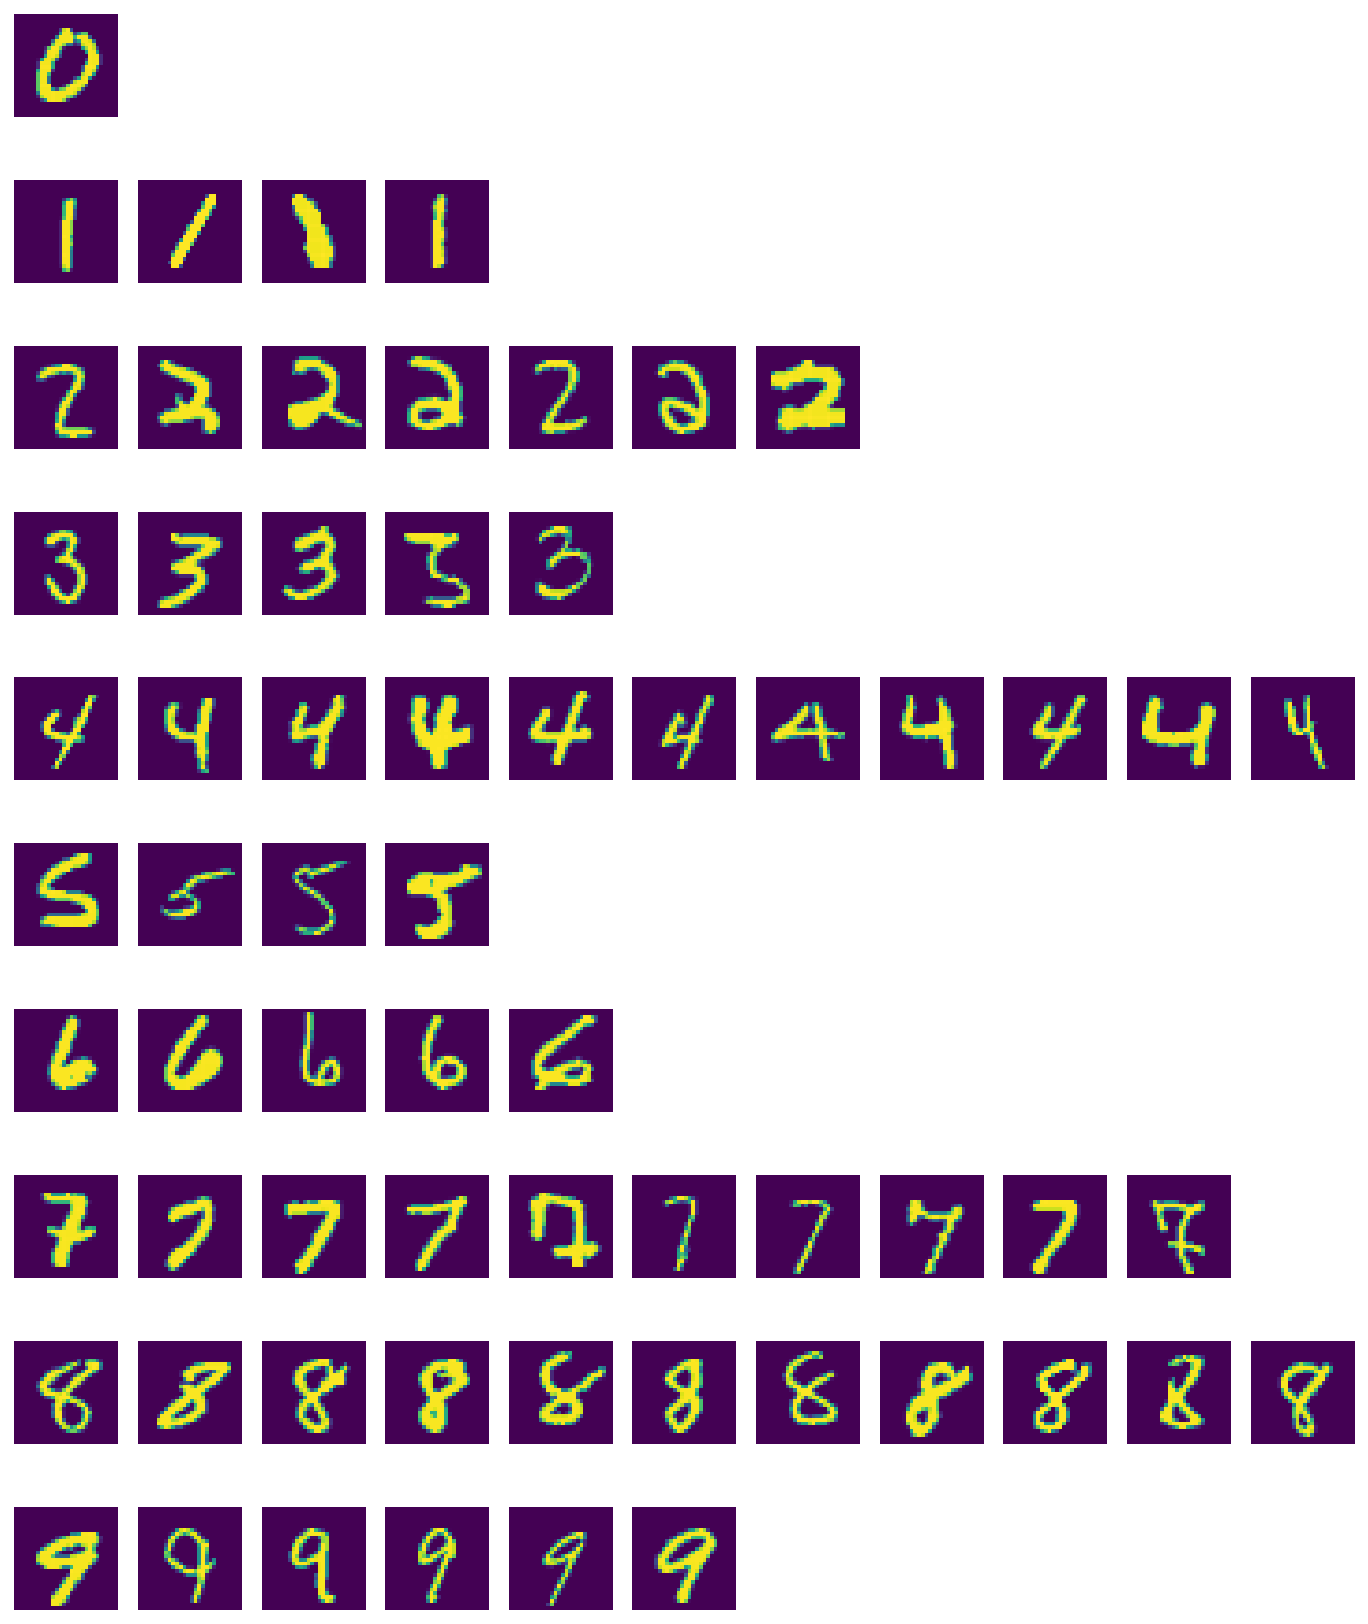

In [12]:
images_dict = {n: [] for n in range(10)}
for image, label in zip(images, labels):
    images_dict[int(label)].append(image)
    
plt.figure(figsize=(12, 15))
width = max([len(images_) for _, images_ in images_dict.items()])
for label, images_ in images_dict.items():
    n = len(images_)
    for i, image in enumerate(images_):
        plt.subplot(10, width, width*label+i+1); plt.axis('off')
        plt.imshow(image.squeeze())
plt.show() 

In [13]:
def presenter(label):
    images_labeled = torch.stack(images_dict[label])
#     for i, image in enumerate(images_labeled): 
#             plt.subplot(1, len(images_labeled), i+1); plt.axis('off'); plt.imshow(image.squeeze())
#     plt.show()
    for i, model in enumerate([M1, M2, M3]):
        data_label0 = model(images_labeled.to(device))
        pi0 = tc2np(data_label0['pi'])
        pi0[pi0 < 1e-3] = 0
#         plt.imshow(pi0, cmap='gray'); plt.axis('off'); plt.show() 
        plt.subplot(1, 3, i+1); plt.imshow(pi0, cmap='viridis'); plt.axis('off')
    plt.show() 

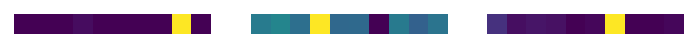

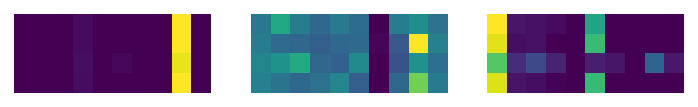

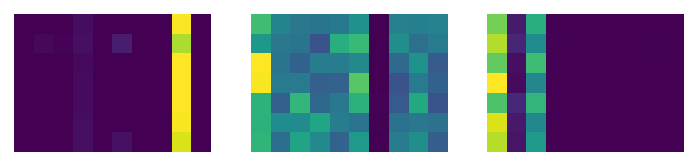

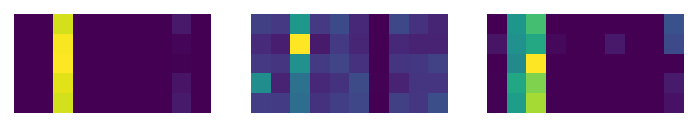

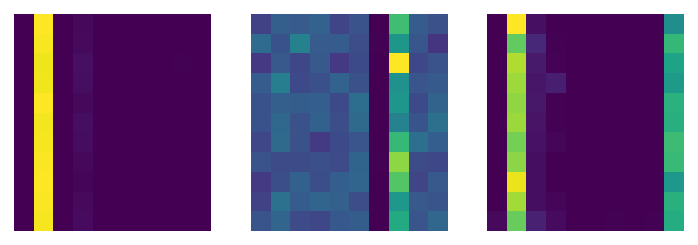

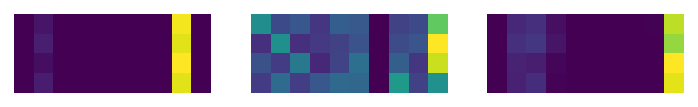

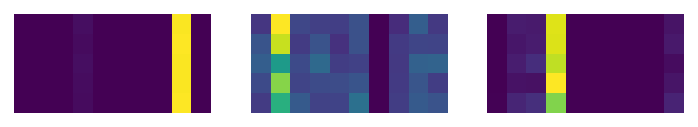

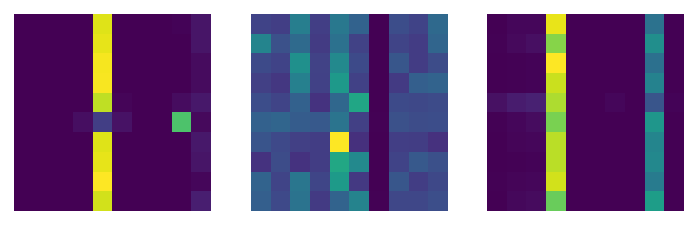

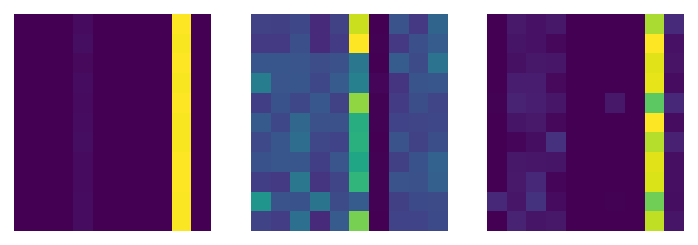

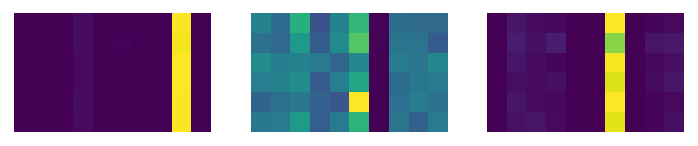

In [14]:
for i in range(10):
    presenter(i) 

epoch:[0/10] loss:[2.498] train_accr:[0.697] test_accr:[0.957].
 [Train] alea:[1.616] epis:[0.552] / [Test] alea:[1.616] epis:[0.552]
epoch:[1/10] loss:[2.334] train_accr:[0.708] test_accr:[0.968].
 [Train] alea:[1.627] epis:[0.558] / [Test] alea:[1.628] epis:[0.558]
epoch:[2/10] loss:[2.308] train_accr:[0.710] test_accr:[0.970].
 [Train] alea:[1.582] epis:[0.564] / [Test] alea:[1.582] epis:[0.564]
epoch:[3/10] loss:[2.292] train_accr:[0.717] test_accr:[0.979].
 [Train] alea:[1.583] epis:[0.565] / [Test] alea:[1.583] epis:[0.565]
epoch:[4/10] loss:[2.283] train_accr:[0.718] test_accr:[0.978].
 [Train] alea:[1.539] epis:[0.564] / [Test] alea:[1.541] epis:[0.565]
epoch:[5/10] loss:[2.273] train_accr:[0.720] test_accr:[0.982].
 [Train] alea:[1.546] epis:[0.567] / [Test] alea:[1.547] epis:[0.568]
epoch:[6/10] loss:[2.264] train_accr:[0.721] test_accr:[0.979].
 [Train] alea:[1.532] epis:[0.571] / [Test] alea:[1.534] epis:[0.572]
epoch:[7/10] loss:[2.255] train_accr:[0.722] test_accr:[0.981]

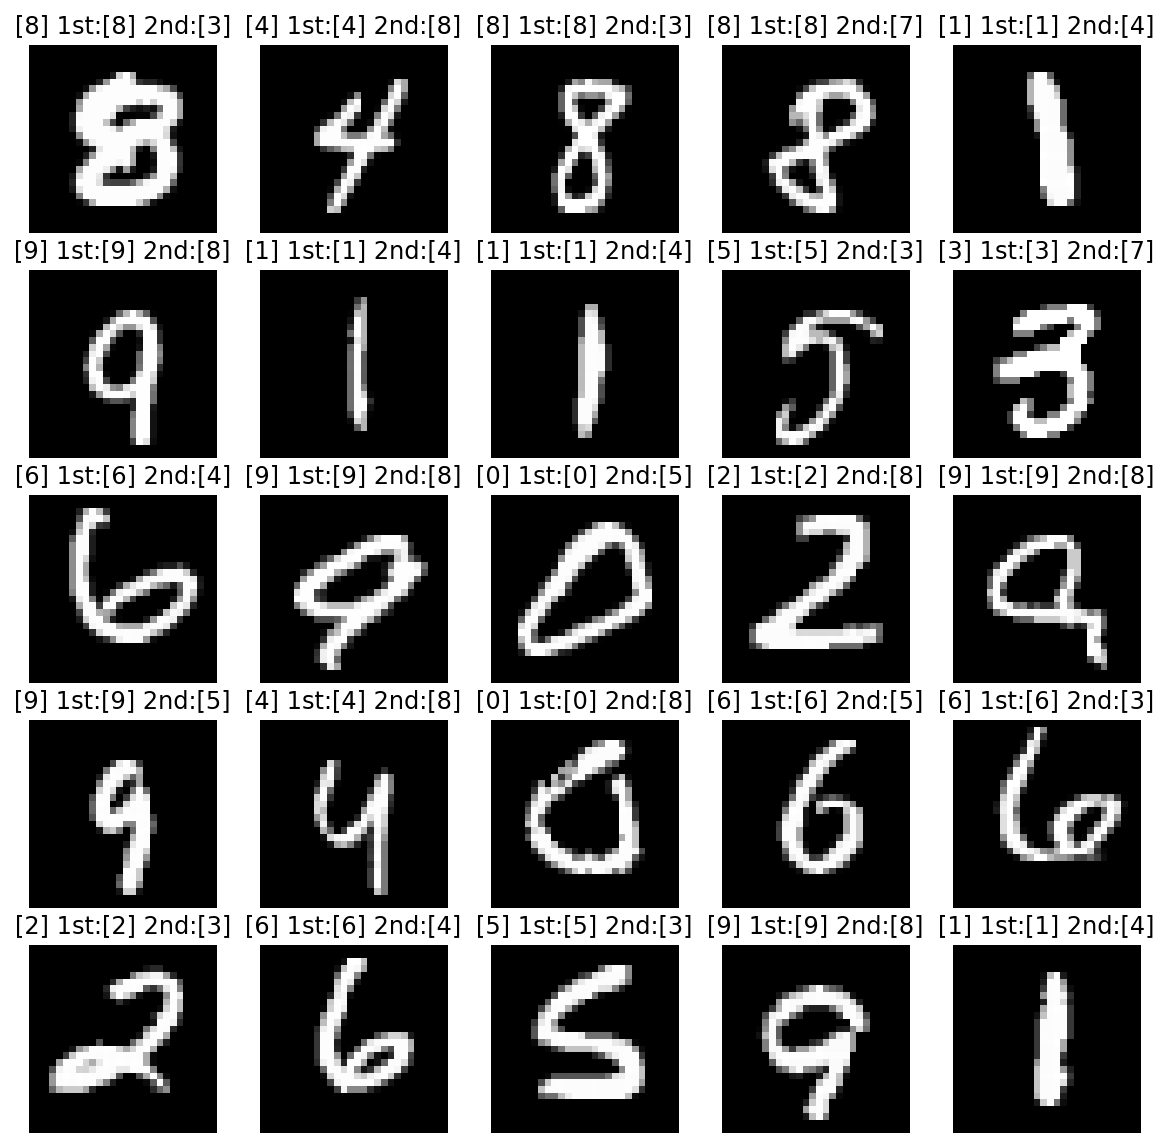

Done
pi:
[[0.02 0.06 0.08 0.06 0.06 0.00 0.00 0.00 0.72 0.00]
 [0.00 0.69 0.03 0.00 0.10 0.00 0.00 0.00 0.13 0.05]
 [0.00 0.08 0.20 0.07 0.14 0.00 0.00 0.00 0.47 0.03]
 [0.00 0.09 0.15 0.06 0.16 0.00 0.00 0.00 0.52 0.02]
 [0.68 0.09 0.08 0.06 0.05 0.00 0.00 0.00 0.05 0.00]]
epoch:[0/10] loss:[2.748] train_accr:[0.363] test_accr:[0.758].
 [Train] alea:[1.799] epis:[0.631] / [Test] alea:[1.800] epis:[0.631]
epoch:[1/10] loss:[2.670] train_accr:[0.371] test_accr:[0.774].
 [Train] alea:[1.806] epis:[0.615] / [Test] alea:[1.806] epis:[0.615]
epoch:[2/10] loss:[2.659] train_accr:[0.412] test_accr:[0.876].
 [Train] alea:[1.802] epis:[0.644] / [Test] alea:[1.803] epis:[0.644]
epoch:[3/10] loss:[2.652] train_accr:[0.414] test_accr:[0.877].
 [Train] alea:[1.764] epis:[0.649] / [Test] alea:[1.765] epis:[0.650]
epoch:[4/10] loss:[2.646] train_accr:[0.416] test_accr:[0.878].
 [Train] alea:[1.793] epis:[0.654] / [Test] alea:[1.794] epis:[0.654]
epoch:[5/10] loss:[2.641] train_accr:[0.418] test_accr:

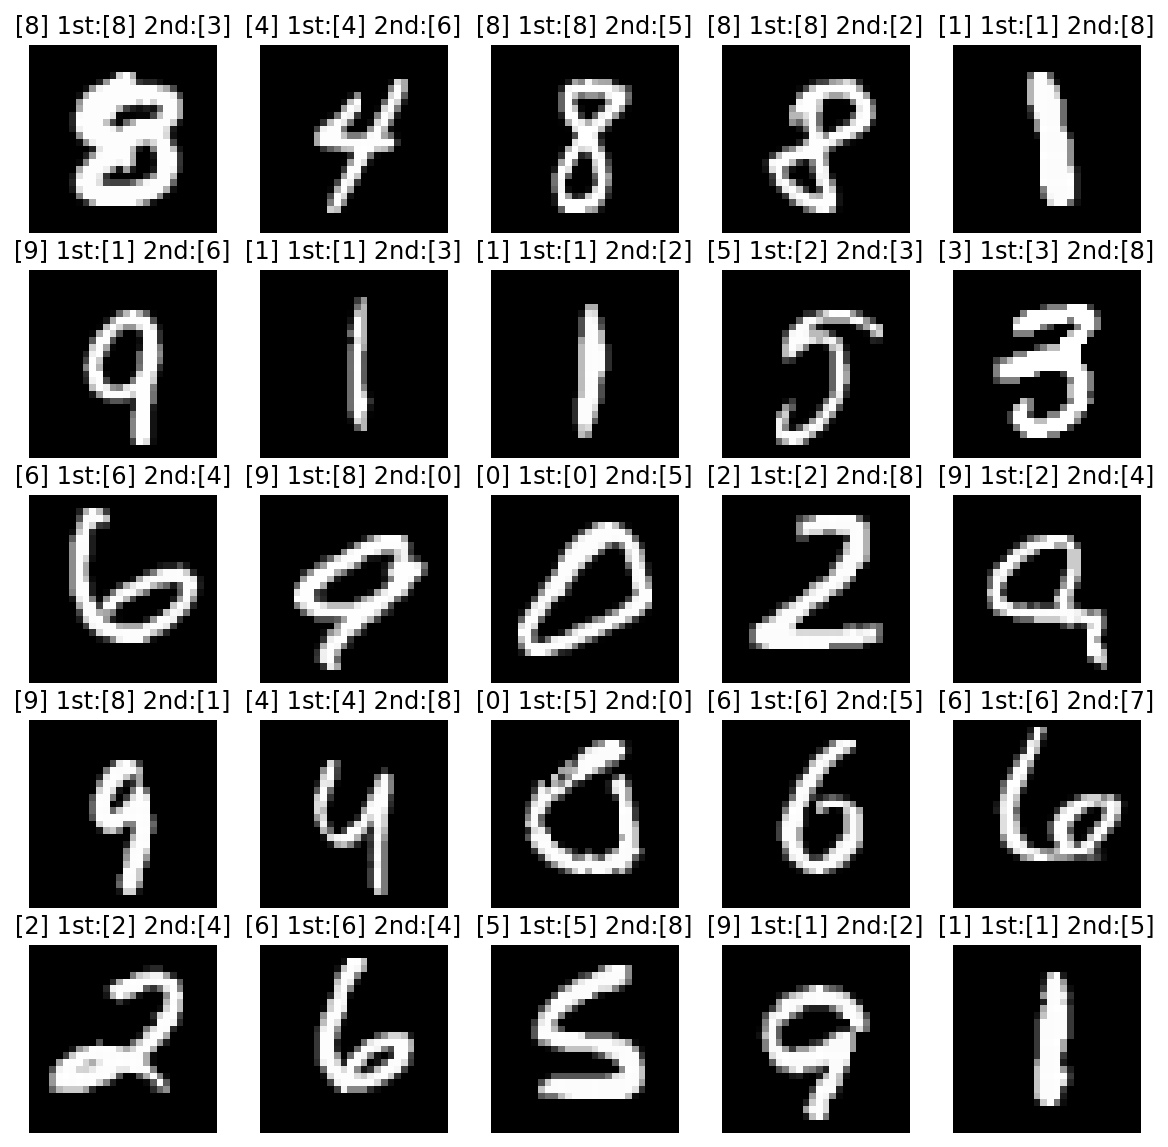

Done
pi:
[[0.06 0.04 0.09 0.08 0.05 0.48 0.05 0.07 0.00 0.08]
 [0.07 0.49 0.06 0.09 0.06 0.08 0.05 0.06 0.00 0.04]
 [0.09 0.05 0.11 0.11 0.10 0.28 0.05 0.11 0.01 0.11]
 [0.07 0.10 0.11 0.10 0.07 0.29 0.05 0.12 0.00 0.08]
 [0.34 0.11 0.10 0.06 0.09 0.12 0.07 0.05 0.00 0.07]]
epoch:[0/10] loss:[2.803] train_accr:[0.125] test_accr:[0.317].
 [Train] alea:[1.889] epis:[0.659] / [Test] alea:[1.889] epis:[0.658]
epoch:[1/10] loss:[2.808] train_accr:[0.141] test_accr:[0.459].
 [Train] alea:[1.877] epis:[0.684] / [Test] alea:[1.877] epis:[0.684]
epoch:[2/10] loss:[2.807] train_accr:[0.159] test_accr:[0.634].
 [Train] alea:[1.870] epis:[0.685] / [Test] alea:[1.870] epis:[0.685]
epoch:[3/10] loss:[2.805] train_accr:[0.173] test_accr:[0.748].
 [Train] alea:[1.878] epis:[0.688] / [Test] alea:[1.878] epis:[0.688]
epoch:[4/10] loss:[2.805] train_accr:[0.172] test_accr:[0.723].
 [Train] alea:[1.874] epis:[0.689] / [Test] alea:[1.874] epis:[0.689]
epoch:[5/10] loss:[2.803] train_accr:[0.174] test_accr:

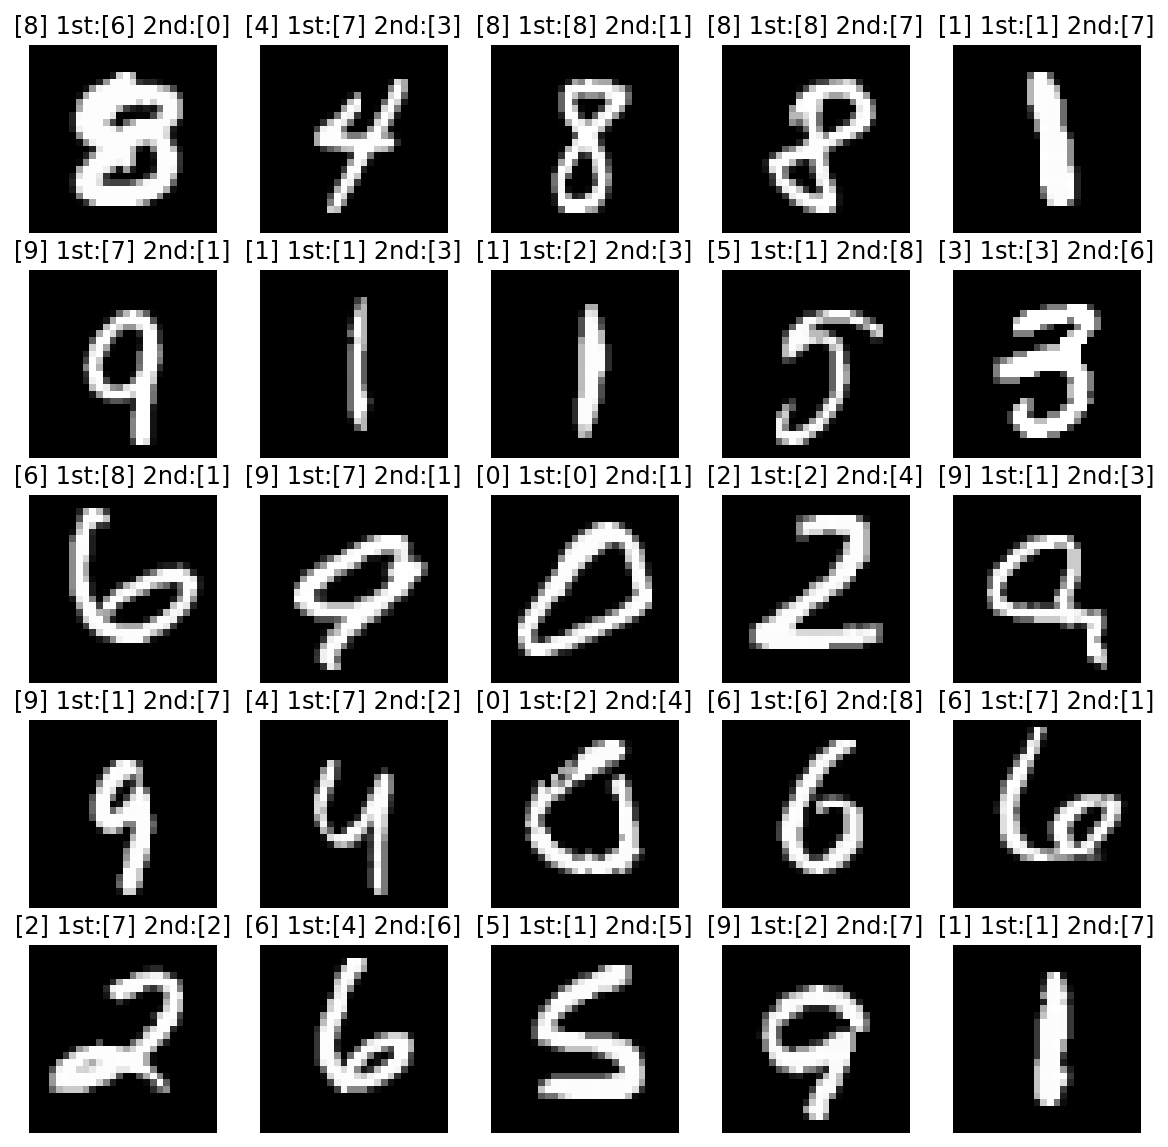

Done
pi:
[[0.13 0.11 0.08 0.16 0.10 0.11 0.06 0.08 0.09 0.09]
 [0.04 0.14 0.17 0.08 0.19 0.08 0.04 0.10 0.08 0.08]
 [0.09 0.06 0.10 0.09 0.12 0.16 0.05 0.09 0.13 0.11]
 [0.09 0.11 0.09 0.09 0.14 0.15 0.05 0.09 0.11 0.08]
 [0.07 0.08 0.11 0.09 0.12 0.08 0.05 0.11 0.19 0.09]]


In [98]:
out4 = train_wrapper(rs_rate=0.3,rp_rate=0.0)
out5 = train_wrapper(rs_rate=0.6,rp_rate=0.0)
out6 = train_wrapper(rs_rate=0.9,rp_rate=0.0) 

In [133]:
def presenter2(model, label, seed):
    np.random.seed(seed=seed)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    images_l = images_dict[label]
    tmp = model(torch.stack(images_l).to(device))
    index = np.random.randint(tmp['pi'].shape[0])
    pi = tmp['pi']
    z = tmp['mu']
    mu_hat = tc2np(torch.softmax(z, 2)[index])
    
#     pi = tc2np(pi[index])
#     pred = np.argmax(mu_hat[np.argmax(pi)]) 
    pred = np.argmax(tc2np(torch.softmax(torch.sum(pi.unsqueeze(2)*z, axis=1), 1)[index]))
    ax1.set_title(f'label: [{label}], pred: [{pred}]')
    ax1.imshow(images_l[0].squeeze()); ax1.axis('off')
               
    ax2.set_title(r'$\mu$')
    im = ax2.imshow(mu_hat)
    ax2.set_ylabel(r'$\pi$')
    ax2.set_xlabel('label')
    ax2.set_xticks(np.arange(9)+.5)
    ax2.set_yticks(np.arange(9)+.5)
    ax2.grid(axis='y')
    ax2.grid(axis='x', alpha=.3)
    
    ax3.set_title(r'$\pi$')
    pi = tc2np(pi[index]) 
    ax3.imshow(pi[:,None], aspect=1); ax3.axis('off')
    
    fig.tight_layout()
    plt.subplots_adjust(left=0, right=1)
    plt.savefig(f'results/result{i}.png')
    plt.show() 
    np.random.seed(seed=0) 

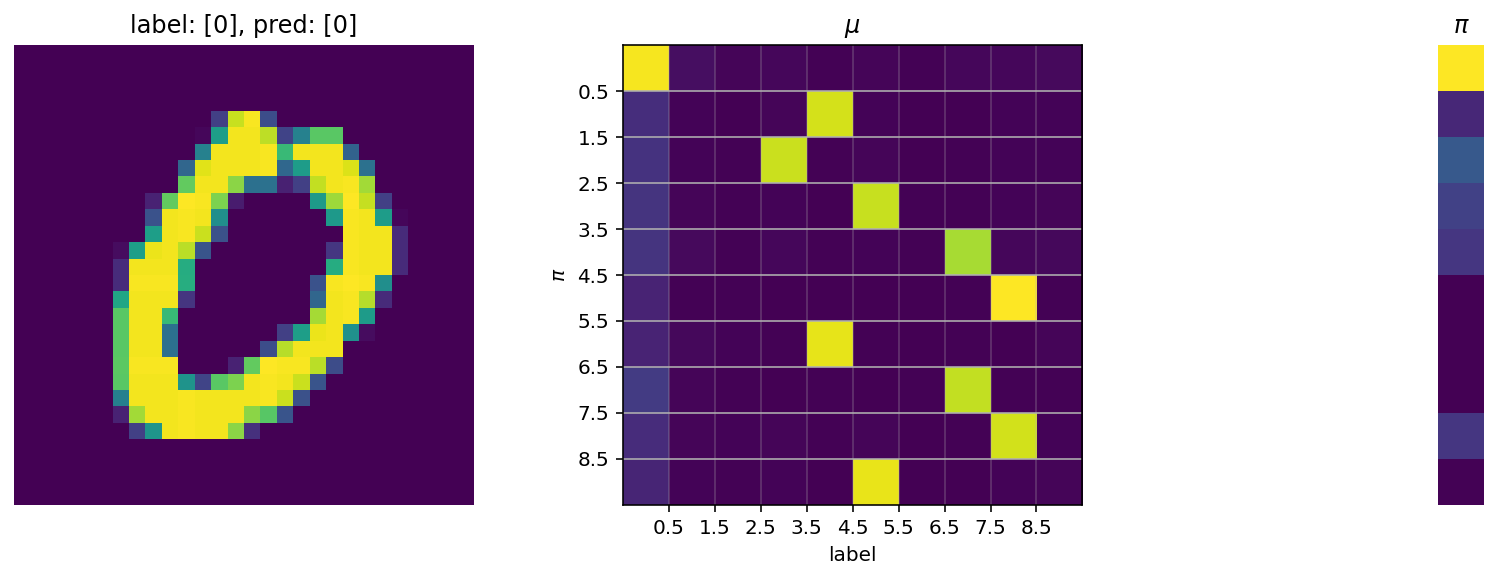

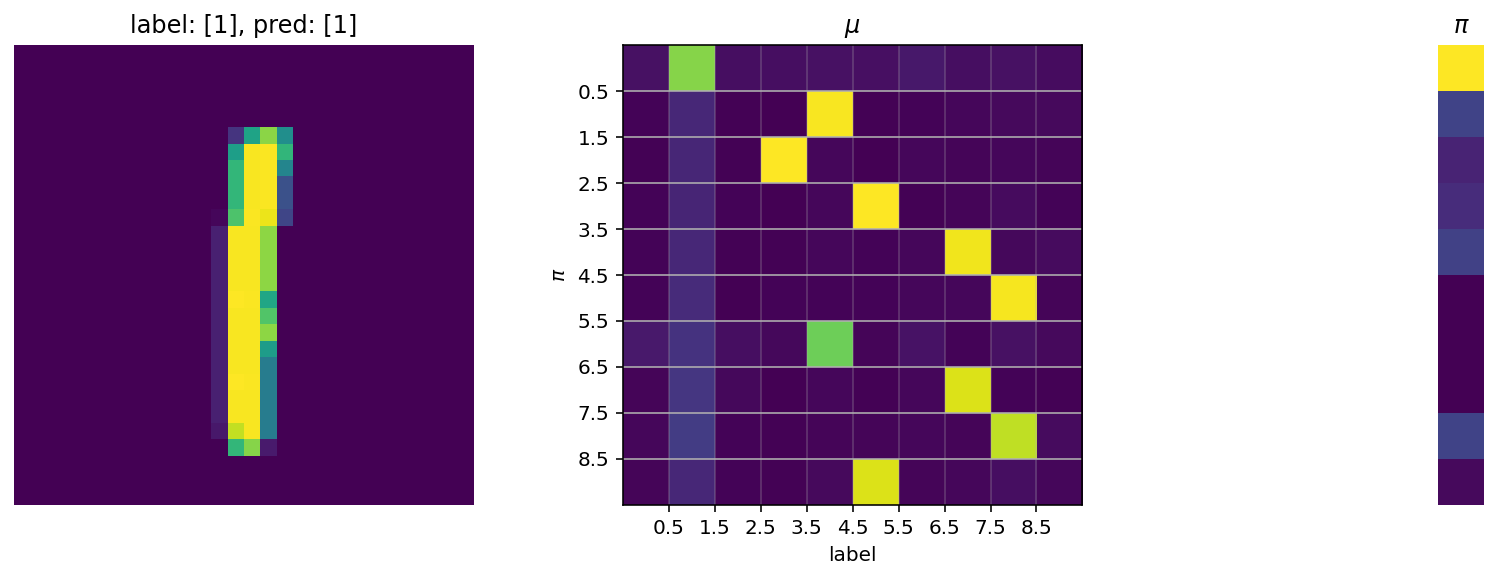

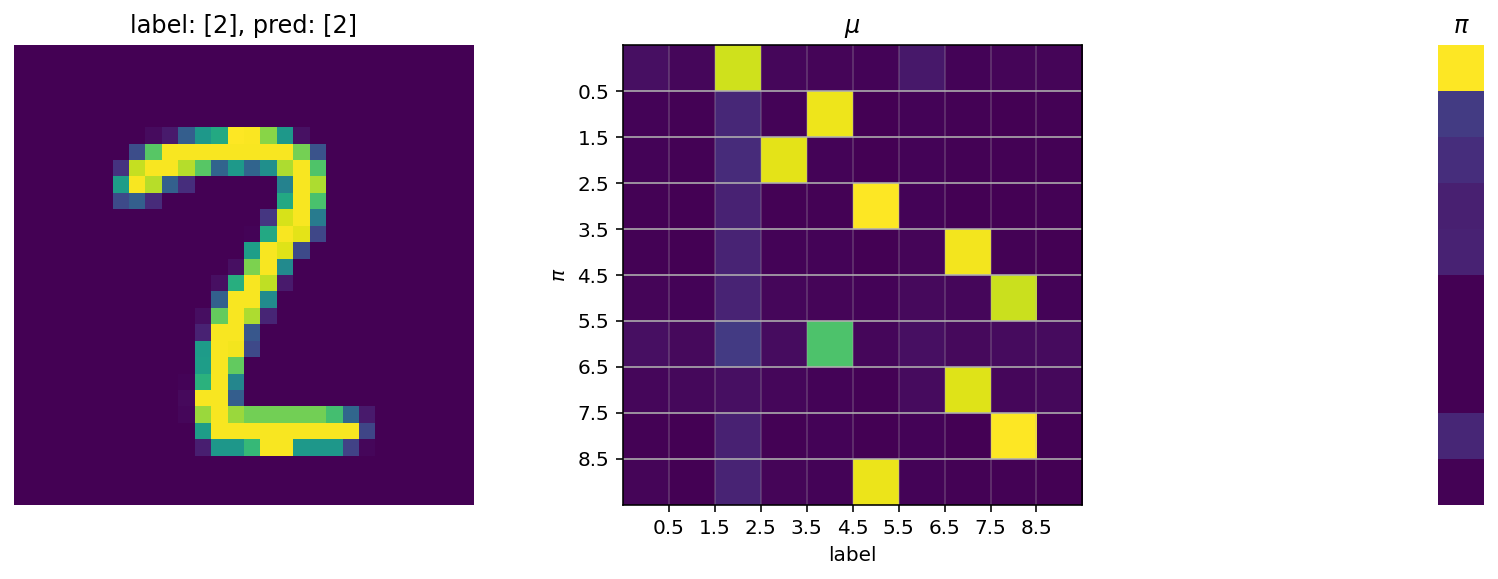

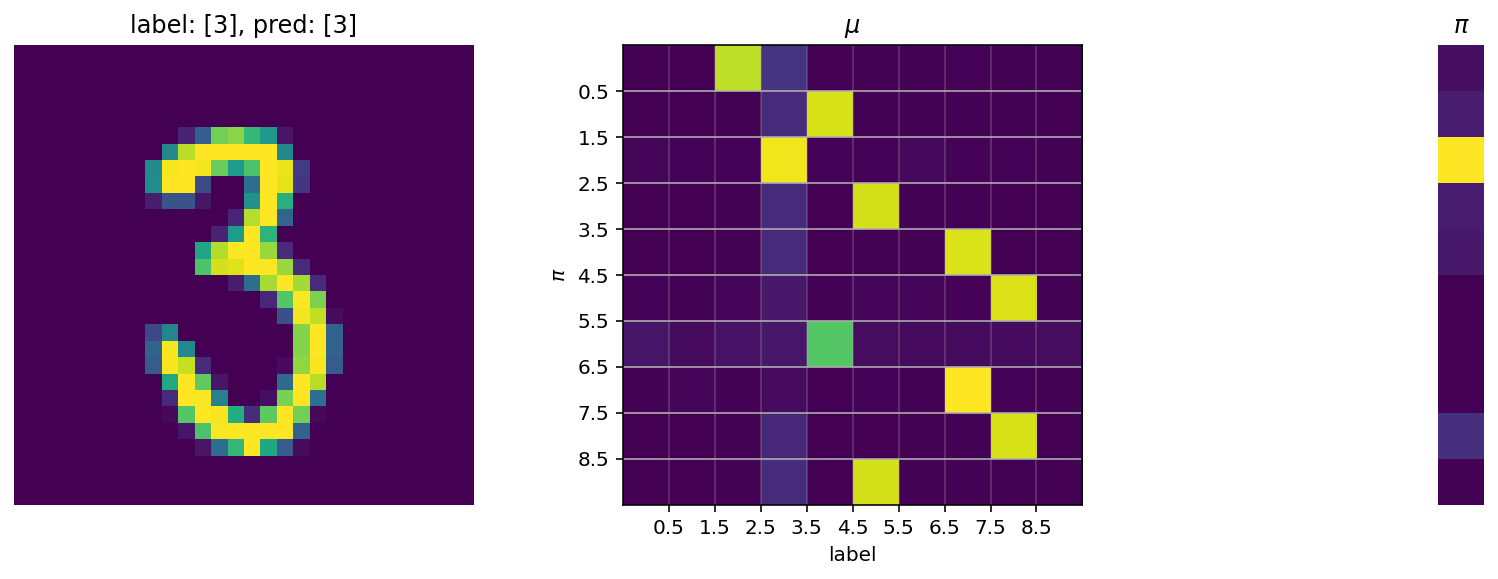

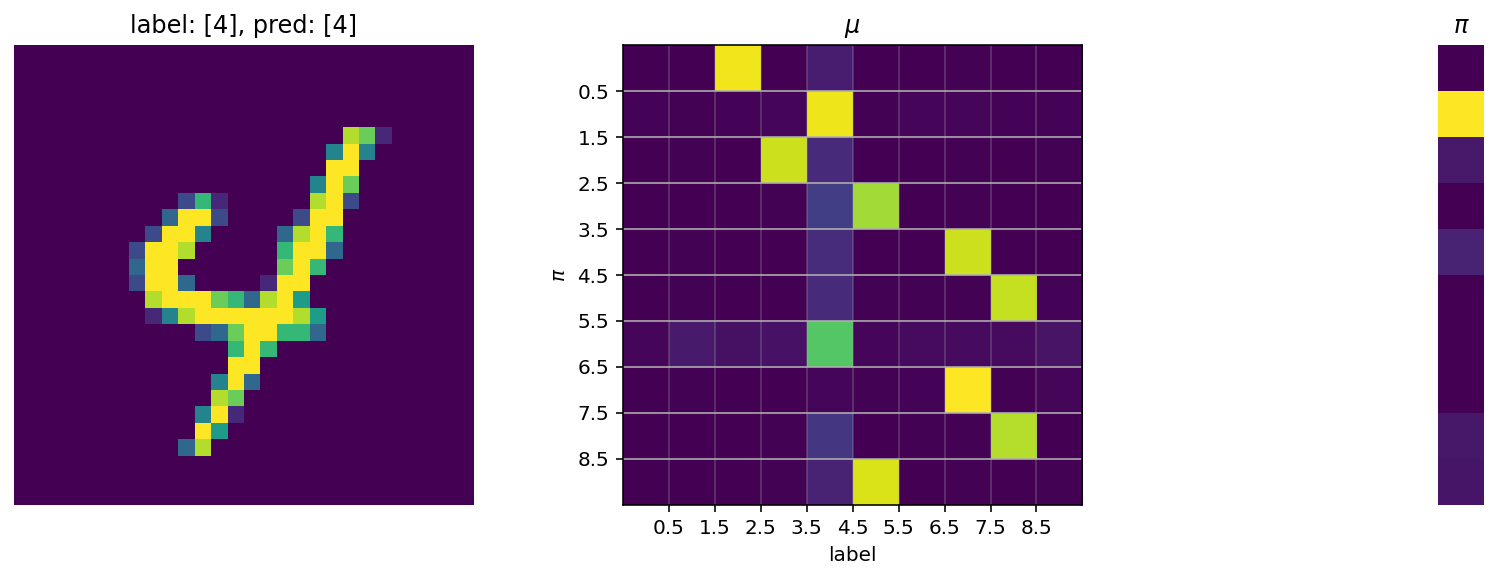

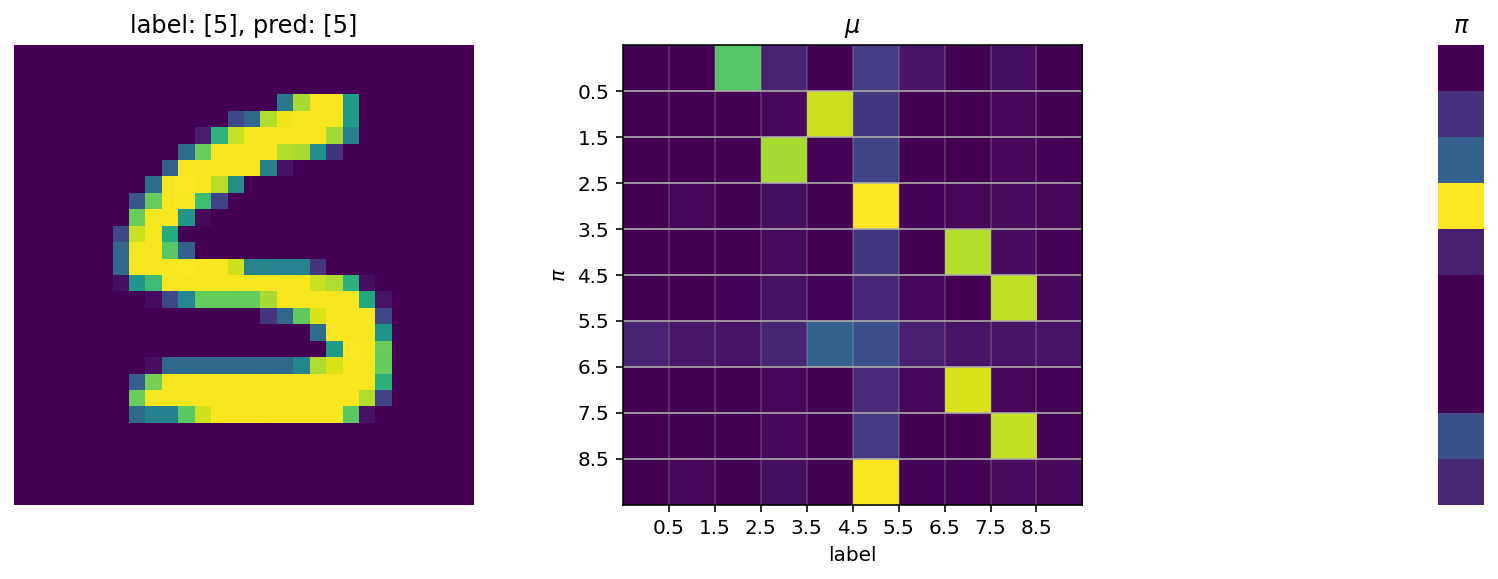

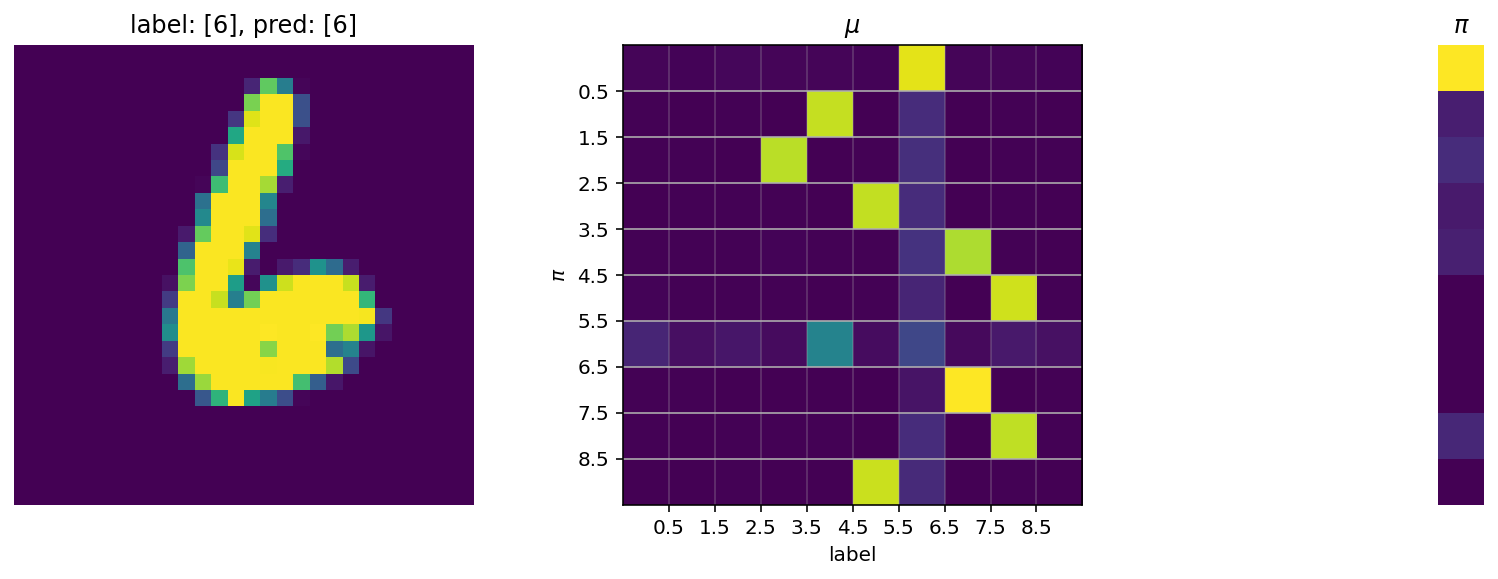

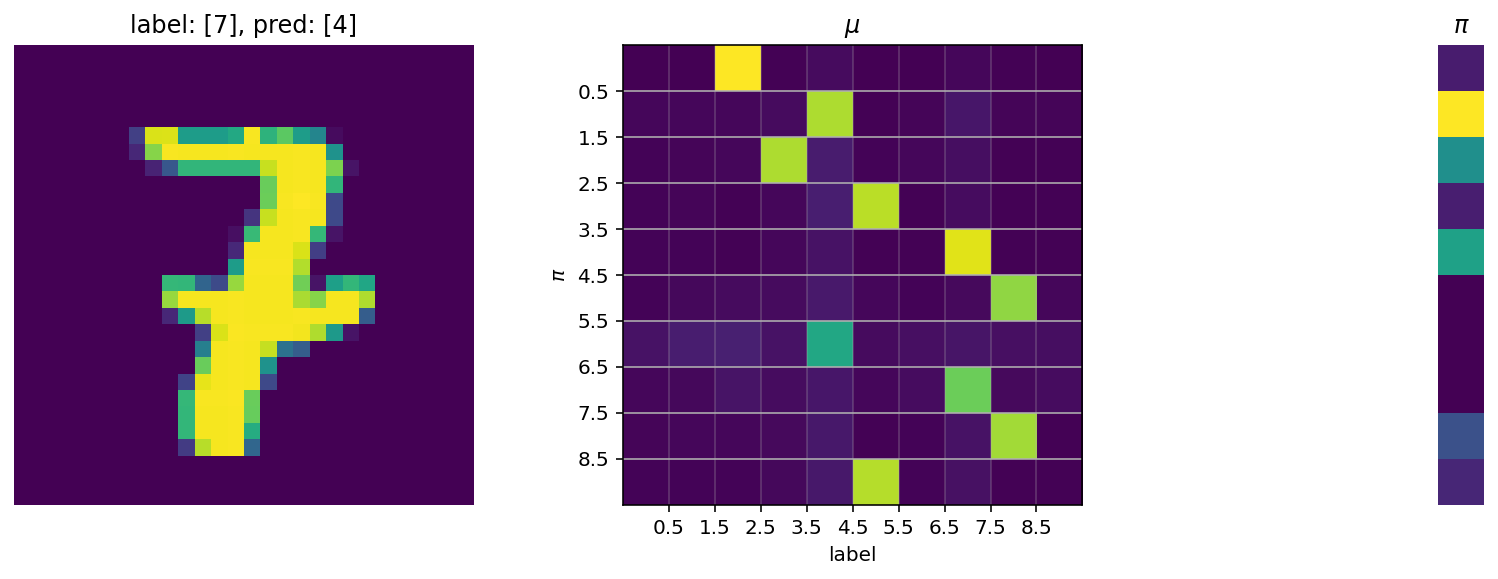

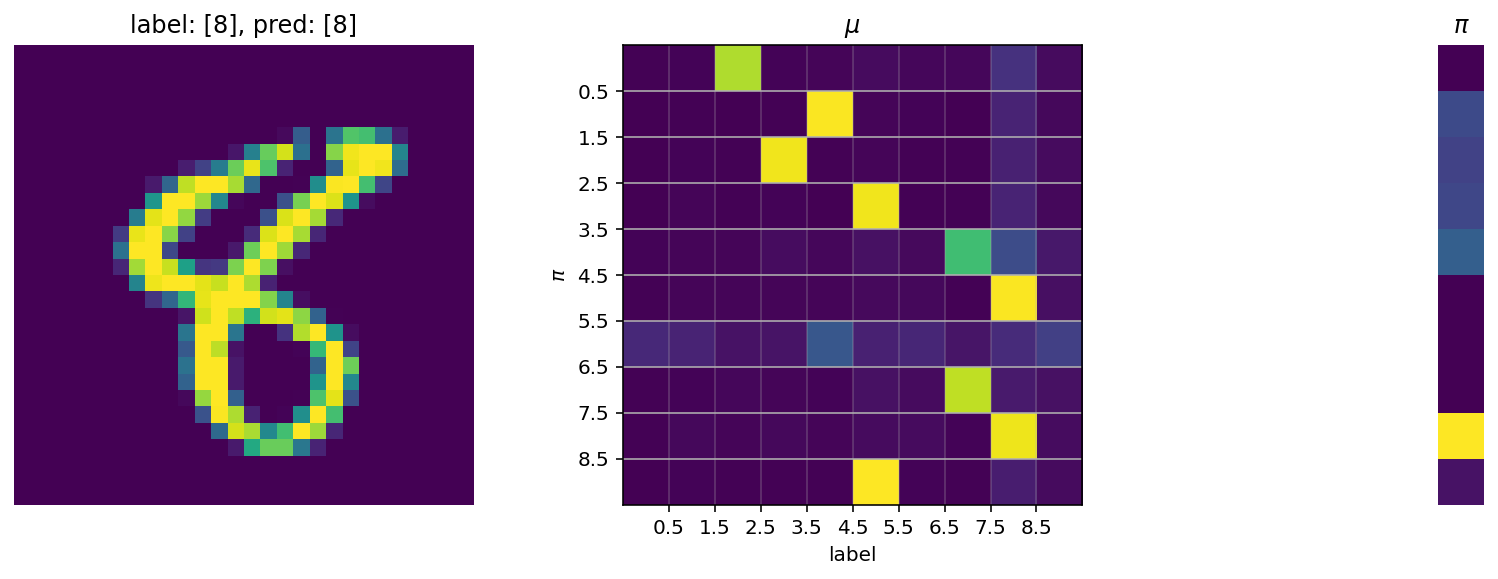

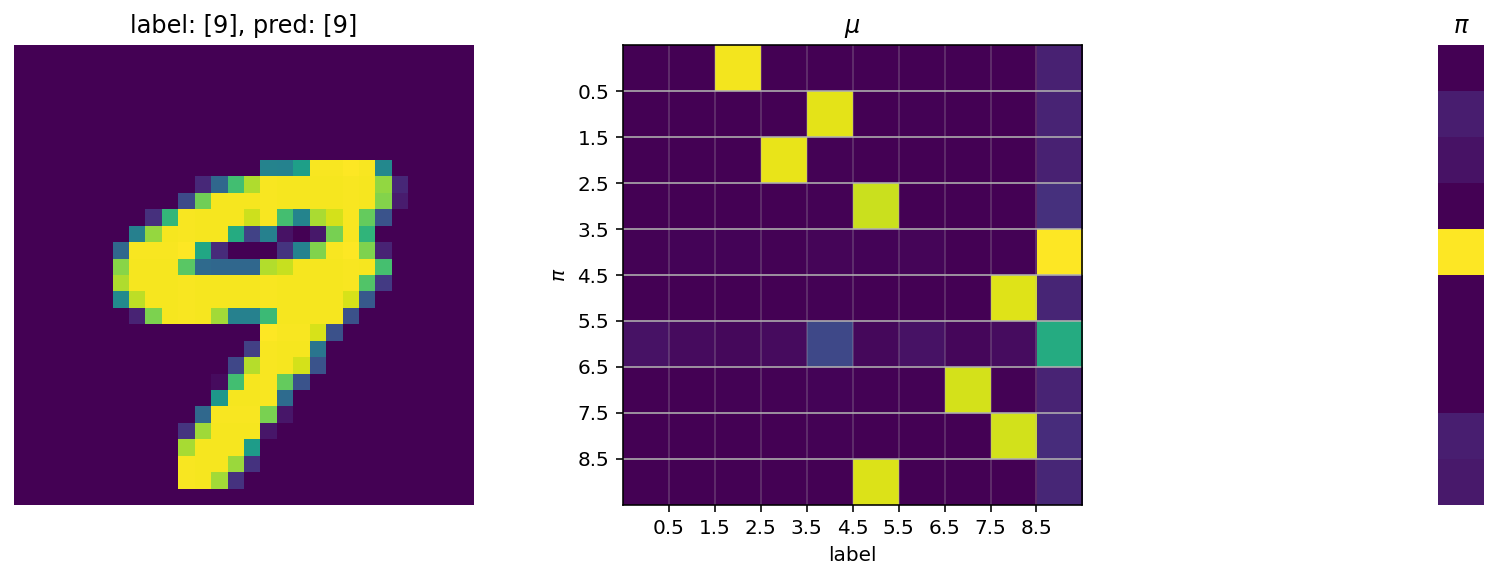

In [180]:
M4, M5, M6 = out4['M'], out5['M'], out6['M']
for i in range(10):
    presenter2(M4, i, 4)

In [150]:
for test_images, test_labels in get_test_iter(BATCH_SIZE=1024):
    break  

In [192]:
print('================= Accuracies ================\nlogit_blended | blended | argmax | noise_rate')
for model, noise_rate in zip([M4, M5, M2, M6], [.3, .6, .8, .9]):  # .3, .6, .8, .9
    with torch.no_grad():
        test_output = model(test_images.to(device)) 
    pi = test_output['pi']  # [N x K]
    mu = test_output['mu']  # [N x K x D]

    logit_blended = torch.sum(pi.unsqueeze(2)*mu, axis=1)  # [N x D]
    logit_blended_pred = torch.argmax(logit_blended, axis=1)  # args: [N]
    logit_blended_acc = torch.sum(logit_blended_pred==test_labels.to(device)) / logit_blended_pred.shape[0]
    
    mu_hat = torch.softmax(mu, axis=2)
    blended = torch.sum(pi.unsqueeze(2)*mu_hat, axis=1)  # [N x D]
    blended_pred = torch.argmax(blended, axis=1)  # args: [N]
    blended_acc = torch.sum(blended_pred==test_labels.to(device)) / logit_blended_pred.shape[0]

    arg_pi = torch.argmax(pi, axis=1)
    arg_pi = arg_pi.unsqueeze(dim=-1).repeat(1,mu.shape[2]).unsqueeze(1)  # [N x 1 x D]
    mu_sel = torch.gather(mu,dim=1,index=arg_pi).squeeze(dim=1)  # [N x D]
    argmax_pred = torch.argmax(mu_sel, axis=1)
    argmax_acc = torch.sum(argmax_pred==test_labels.to(device)) / logit_blended_pred.shape[0]
    
    print(f'{tc2np(logit_blended_acc):>13.2%} | {tc2np(blended_acc):>7.2%} | {tc2np(argmax_acc):.2%} | {noise_rate:<10.0%}')

================= Accuracies ================
logit_blended | blended | argmax | noise_rate
       98.14% |  97.95% | 97.66% | 30%       
       94.34% |  91.21% | 85.16% | 60%       
       83.30% |  76.76% | 76.86% | 80%       
       62.70% |  60.55% | 59.18% | 90%       
